In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def find_maxima(data, nmax=10, threshold=0):
    if data is None:
        return None
    peak = []
    for index in range(1,len(data)-1):
        if data[index]>data[index-1] and data[index]>data[index+1]:
            omega_list = np.arange(index-1,index+2)
            Vlist = data[index-1:index+2]
            T = np.array([omega_list**2, omega_list, np.ones(omega_list.shape)]).T
            coeff = np.linalg.inv(T)@Vlist
            max_position = -coeff[1]/(2*coeff[0])
            max_value = np.array([max_position**2, max_position, 1]) @ coeff
            if max_value >threshold:
                peak.append([max_position, max_value])
    return np.array(sorted(peak, key=lambda x: x[1])[::-1])[:nmax]

# Wavelet transformation with FFT

The wavelet transformation is a Fourier transformation of a localized function:
$$
    F(t, \omega) = \frac{e^{-i\omega t}}{2T} \int\limits_{-\infty}^\infty\! d\tau\, W(\frac{\tau-t}T) e^{i\omega \tau} f(\tau),    
$$
where the $W$ window function satisfies
$$
   W(0)=1,\qquad W(\pm 1)=0, \qquad W(x) + W(1+x) = 1\quad\mathrm{for}\;x\in\{0,1\}. 
$$
For example
$$
    W(x) = \left\{\begin{array}{cc}
         1-f(x+1)\;&\mathrm{for}\; -1<x<-1/2  \\
         f(x)\;& \mathrm{for}\; -1/2<x<1/2 \\
         1-f(x-1)\;& \mathrm{for}\; 1/2<x<1
    \end{array}\right.
$$
Then
$$
    W(1+x) = \left\{\begin{array}{cc}
         1-f(x)\;&\mathrm{for}\; 0<x<1/2  \\
         f(x-1)\;& \mathrm{for}\; 1/2<x<3/2 \\
         1-f(x-2)\;& \mathrm{for}\; 3/2<x<2
    \end{array}\right.,
$$
and the sum rule is satisfied. For continuity $f(x)$ function then must satisfy $f(1)=1/2$, and for window-like function is has to take $f(0)=1$, but otherwise arbitrary. For example
$$
    f(x) = \frac 1{1+(2x)^p}
$$
with any $p$.

The sum rule exnsures that
$$
    \frac1{2T}\sum\limits_{n=-\infty}^\infty e^{in\omega T} F(t+nT,\omega) = {\cal F}(f)(\omega),
$$
where $\cal{F}$ denotes the Fourier transformation.

On the other hand
$$
    \int\limits_{-\infty}^\infty\frac{d\omega}{2\pi} 2Te^{i\omega t} e^{-i\omega \tau} F(t, \omega) = W(\frac{\tau-t}T) e^{i\omega \tau} f(\tau).
$$



In [3]:
def W(x, power=6):
    f = lambda z:1/(1+(2*z)**power)
    if x<-1:
        return 0
    elif x<-0.5:
        return 1-f(x+1)
    elif x<0.5:
        return f(x)
    elif x<1:
        return 1-f(x-1)
    else:
        return 0

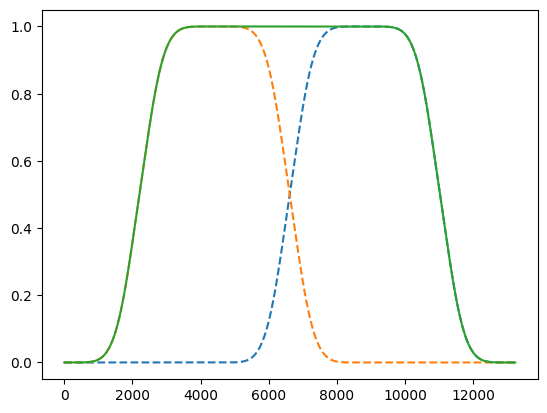

In [4]:
sample_rate = 44100 #Hz
dt = 1/sample_rate
T_int=0.1 #sec
N_T = int(sample_rate*T_int)
xrange = range(-N_T, N_T)
W_vector = np.array([ W(n/(sample_rate*T_int)) for n in xrange])

W1 = np.concatenate((np.zeros(N_T), W_vector))
W2 = np.concatenate((W_vector, np.zeros(N_T)))
plt.plot(W1,'--')
plt.plot(W2,'--')
plt.plot(W1+W2)


## Perform the integral with FFT

With the new variable $x = \tau-t$, we can write
$$    
    F(t, \omega) = \frac1{2T}\int\limits_{-T}^T\! dx\,  e^{i\omega x} W(\frac xT) f(t+x).
$$
The $f$ function is given as a vector $f_n = f(n\,dt)$, where $dt$ is the inverse of the sampling frequency $\nu_{sample}$. We can vectorize the window function, too: $W_n = W(\frac{n\,dt}T-1)$ for $n\in[0,2N_T]$ with $N_T=T/dt$.

So the integral is naturally discretized
$$
    F_n(\omega) = \frac1{2N_T}\sum\limits_{m=-N_T}^{N_T-1}  e^{im \omega dt} W_{m+N_T} f_{n+m}.
$$

We can think that this function is periodic with period $2T$. Then the possible frequency values are
$$ \omega_k = k\frac\pi T $$
and so
$$ F_{nk} = \frac1{2N_T} \sum\limits_{m=-N_T}^{N_T-1}  e^{2\pi i\, mk /(2N_T)} W_m f_{n+m}.$$
Shifting the $m$ index by $N_T$ we find
$$ F_{nk} = \frac{(-1)^k}{2N_T}\sum\limits_{m=0}^{2N_T-1}  e^{-2\pi i\, mk /(2N_T)} W_m f_{n+m-N_T}.$$
This is exactly the inverse discrete Fourier transform (iDFT), up to a sign:
$$ F_n = \mathrm{iDFT}(W f^{(n-N_T)}) $$
where $f^{(\ell)}_n=f_{\ell+n}$

## Harmonic function

The most simple example is the harmonic function $f=e^{i\omega_0 t}$. Its Fourier transform is Dirac-delta concentrated at $\omega=\omega_0$. The window function causes it a somewhat broader function
$$ F = iDFT(W ) $$
As the figure below suggests, for $T=0.1$ sec, the effective band width is about 20 Hz.

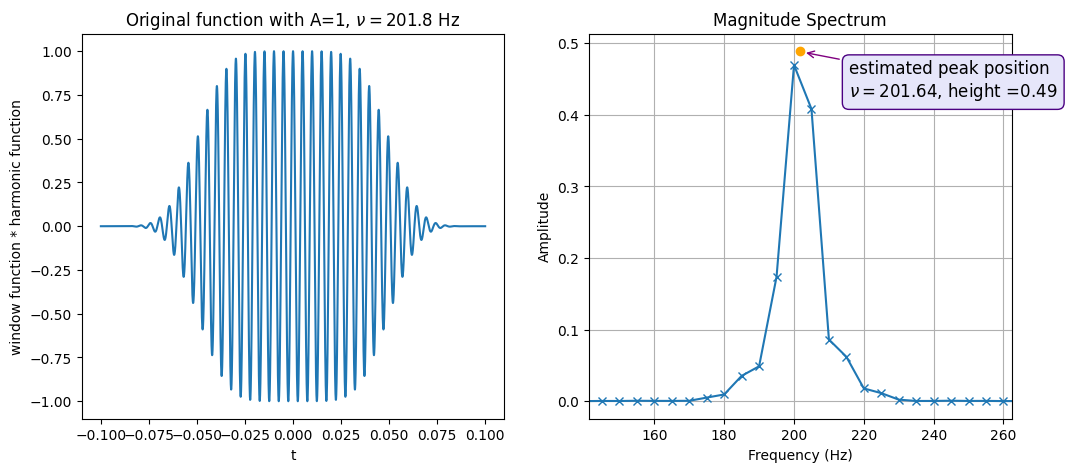

In [5]:
sample_rate = 44100 #Hz
dt = 1/sample_rate
T_int=0.1 #sec
N_T = int(sample_rate*T_int)
xrange = np.arange(-N_T, N_T)
W_vector = np.array([ W(n/(sample_rate*T_int)) for n in xrange])
norm = np.sqrt(np.sum(W_vector**2)/(2*N_T))

O = 201.8 #Hz
A=1
f = np.cos(2*np.pi*O*xrange*dt)

# Compute iFFT
fft_values = 2*np.fft.ifft(W_vector*f)[:N_T]
frequencies = np.fft.fftfreq(2*N_T, d=dt)[:N_T]

dnu = frequencies[1]-frequencies[0]
mx = find_maxima(np.abs(fft_values))[0]

ncols=2
fig,ax = plt.subplots(ncols=ncols, figsize=((ncols*6),5))

ax[0].plot(dt*xrange, W_vector*f)
ax[0].set_xlabel('t')
ax[0].set_ylabel('window function * harmonic function')
ax[0].set_title(f'Original function with A={A}, ' +  r'$\nu=$' + f'{O} Hz')
# Plot magnitude spectrum
ax[1].plot(frequencies, np.abs(fft_values), 'x-')
#ax[1].set_xscale('log')
ax[1].set_xlabel("Frequency (Hz)")
ax[1].set_ylabel("Amplitude")
ax[1].set_title("Magnitude Spectrum")
ax[1].set_xlim(0.7*O, 1.3*O)
ax[1].scatter(mx[0]*dnu,mx[1], color='orange')
plt.annotate("estimated peak position\n" + r'$\nu=$' + f'{mx[0]*dnu:.2f}, height ={mx[1]:.2f}',
             xy=(mx[0]*dnu*1.005,mx[1]*0.997),               # point to annotate
             xytext=(mx[0]*dnu*1.07,mx[1]*0.87),       # position of the text
             arrowprops=dict(arrowstyle="->", color='purple'),
             bbox=dict(boxstyle="round,pad=0.4", facecolor="lavender", edgecolor="indigo"),
             fontsize=12)
ax[1].grid(True)
plt.show()

## Power

The height of the peak in a harmonic function is in connection with the full power in the original and in the Fourier transformed expresison.

The total power of the original function:
$$    
    P(t) = \frac1{2T} \int\limits_{-T}^T\! dx\, \left(W(\frac xT) f(t+x)\right)^2.
$$
If the frequency is much larger than the $1/T$, then we expect that is can be approximated as
$$
    P(t) \approx \frac1{2T} \int\limits_{-T}^T\! dx\, W^2(\frac xT) \int\limits_{-T}^T\! dx\,  f^2(t+x) = \frac{\cal N}{2T} \int\limits_{-T}^T\! dx\,  f^2(t+x),
$$
where the normalization factor is a constant
$$
    {\cal N} = \frac12\!\int\limits_{-1}^1\! dx\, W^2(x).
$$

By the Fourier transformation properties we know that
$$
    P(t) = \sum_{k=0}^{2N_T-1} |\mathrm{iDFT}(Wf)_k|^2 = 2 \sum_{k=0}^{N_T-1} |\mathrm{iDFT}(Wf)_k|^2,
$$
for real valued functions.

Therefore, the following expressions should be the same:
$$
    {\left\langle f^2(t+x) \right\rangle}_x\approx \frac1{2T{\cal N}} \int\limits_{-T}^T\! dx\, \left(W(\frac xT) f(t+x)\right)^2\approx \frac{2}{{\cal N}} \sum_{k=0}^{N_T-1} |\mathrm{iDFT}(Wf)_k|^2.
$$
The deviation can accur at low frequencies, where the separation of the $W$ and the $f$ integrals is not valid; numerically the above relations are true for $T_{int}\nu>2$.

In [6]:
dx = 1e-3
xrange = np.arange(-1, 1, dx)
W_vector = np.array([ W(x) for x in xrange])
norm = np.sum(W_vector**2)*dx/2
norm

np.float64(0.43270470437550435)

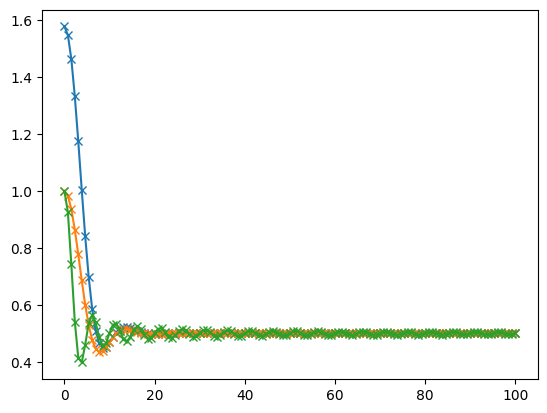

In [7]:
sample_rate = 44100 #Hz
dt = 1/sample_rate
T_int=0.1 #sec
N_T = int(sample_rate*T_int)
xrange = np.arange(-N_T, N_T)
W_vector = np.array([ W(n/(sample_rate*T_int)) for n in xrange])

A=1
O_range = np.linspace(0, 100, 131)
power = []
powerf = []
powerfW = []
for O in O_range:
    f = np.cos(2*np.pi*O*xrange*dt)
    fW = W_vector*f
    # Compute FFT
    fft_values = np.fft.ifft(fW)[:N_T]
    frequencies = np.fft.fftfreq(len(W_vector), d=dt)[:N_T]
    power.append(2*np.sum(np.abs(fft_values)**2)/norm)
    powerf.append(np.sum((fW)**2)/(2*N_T)/norm)
    powerfW.append(np.sum(f**2)/(2*N_T))
plt.plot(O_range, np.array(power),'x-')
plt.plot(O_range, np.array(powerf),'x-')
plt.plot(O_range, np.array(powerfW),'x-')

In [8]:
N_octave = 24
rfactor = 2**(1/N_octave)-1
rfactor

0.029302236643492074

## Logarithmic spectrum

At high frequencies the spactrum usually very messy, if the basic resonance frequencies are resided at low frequancies, say at 100-2000 Hz. To take into account this observation, we shall compute the logarithmic spectrum.

In general in the cumulative spectra the main objective is to maintain the energy relations, because the phases are expected to be random at large frequencies. Therefore we single out frequency windows with corner points $(\omega_0,\omega_1,\dots,\omega_n)$, and instead of the original frequencies, we take into account the power determined by the frequency intervals.
$$ P_{n\alpha} =  2 \sum_{k=k_\alpha}^{k_{\alpha+1}} |\mathrm{iDFT}(Wf)_k|^2. $$
Clearly the total power is the same
$$ P_n = \sum_\alpha P_{n\alpha}. $$
For the phase we compute
$$ F_{n\alpha} = \sum_{k=k_\alpha}^{k_{\alpha+1}} \mathrm{iDFT}(Wf)_k. $$
If there is a dominant frequency, $F$ will have a definite phase. If there are a lot of random contributors, then $F$ will have a random phase. We associate the phase of the frequency window $\alpha$ with the phase of $F_{n\alpha}$.

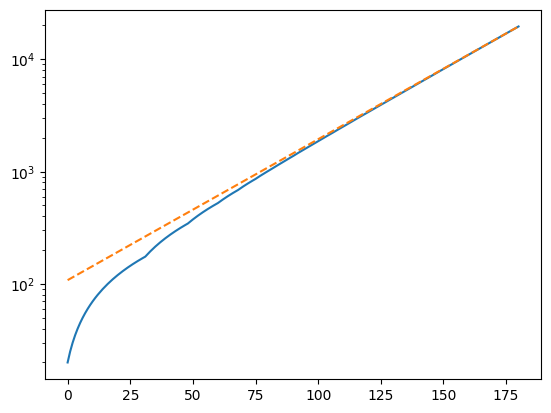

In [9]:
sample_rate = 44100 #Hz
dt = 1/sample_rate
T_int=0.1 #sec
N_T = int(sample_rate*T_int)
xrange = np.arange(-N_T, N_T)
W_vector = np.array([ W(n/(sample_rate*T_int)) for n in xrange])
norm = np.sqrt(np.sum(W_vector**2)/(2*N_T))
frequencies = np.fft.fftfreq(2*N_T, d=dt)[:N_T]

numin = 20 #Hz
numax = 20000 #Hz
N_octave = 24

lf = [numin]
for nu in frequencies:
    if nu<numin or nu>numax:
        continue
    if np.log2(nu/lf[-1])*N_octave >1:
        lf.append(nu)
lf=np.array(lf)
plt.plot(lf,'-')
fr_range = np.arange(len(lf))
plt.plot(lf[-1]* 2**(-fr_range[::-1]/N_octave),'--')
plt.yscale('log')

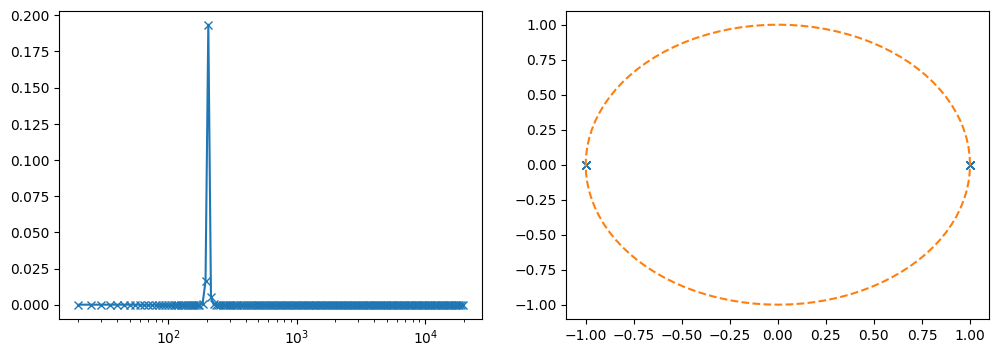

In [16]:
O = 201.8 #Hz
A=1
fW = W_vector*np.cos(2*np.pi*O*xrange*dt)
sign_vector = np.array([(-1)**n for n in range(N_T)])
fft_values = np.fft.ifft(fW)[:N_T]

fft_values = sign_vector*np.fft.ifft(fW)[:N_T]
Plog = [0]
philog = [0]
jlog = 0

for i,fft in enumerate(fft_values):
    if frequencies[i] > lf[jlog]:
        jlog+=1
        if jlog==len(lf):
            break
        Plog.append(0)
        philog.append(0)
    Plog[-1] += 2*np.abs(fft)**2
    philog[-1] += fft
Plog = np.array(Plog)
philog = np.angle(philog)/np.pi

ncols=2
fig, ax = plt.subplots(ncols=ncols, figsize=(6*ncols,4))
ax[0].plot(lf,Plog, 'x-')
ax[0].set_xscale('log')

U = np.angle(fft_values)
ax[1].plot(np.cos(U), np.sin(U), 'x')
ax[1].set_xlim(-1.1,1.1)
ax[1].set_ylim(-1.1,1.1)

philist = np.linspace(0,2*np.pi,101)
ax[1].plot(np.cos(philist), np.sin(philist), '--')
#ax[1].hist(np.angle(fft_values), bins=100)
plt.show()
#ax[1].set_xscale('log')